Advanced lane finding project 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
## Undistortion function

def cal_undistort_coef(img, objpoints, imgpoints): 
    '''
    Calibration of the camera using OpenCV Calibrate camera function
    '''
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None) 
    undist = cv2.undistort(img,mtx,dist,None,mtx) 
    return mtx, dist


In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Mtx and dist save the undistortion coeficients 
mtx, dist = cal_undistort_coef(img,objpoints,imgpoints)        


(-0.5, 1279.5, 719.5, -0.5)

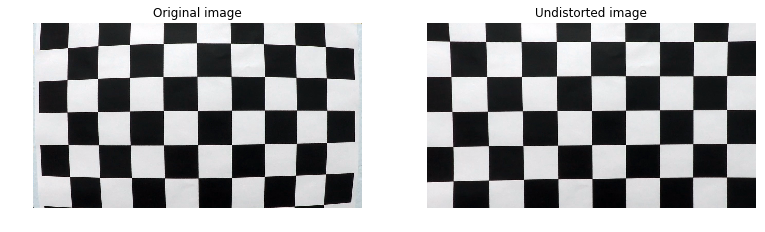

In [4]:
img = cv2.imread(images[0])

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)                      #Plot the raw image
plt.title("Original image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.undistort(img,mtx,dist,None,mtx))                #Plot the undistorted image
plt.title("Undistorted image")
plt.axis('off')

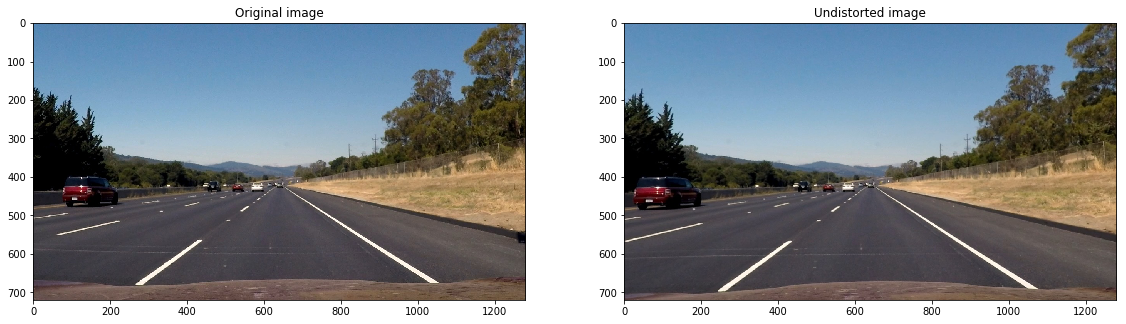

In [5]:
## IMAGE SELECTION FOR TEST POURPOUSES
test_images = glob.glob('test_images/*.jpg')
img_or = cv2.imread(test_images[2])
img = cv2.cvtColor(cv2.undistort(img_or,mtx,dist,None,mtx),cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_or,cv2.COLOR_BGR2RGB))   # Plot the raw image
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(img)            #Plot the undistorted image
plt.title("Undistorted image")

In [6]:
def tresholds(img):
    '''
    Image lanes isolating pipeline 
    '''
    # Convert to HLS color space and isolate the S channel
    #img = warp(img,M)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the gradient in x
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the gradient in x
    abs_sobely = np.absolute(sobely) 
    scaled_sobel_y = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    thresh_min = 20    #Minimum sobel treshold
    thresh_max = 110   #Maximum sobel treshold 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 # Sobel binary
    
    # Threshold y gradient
    thresh_min = 20    #Minimum sobel treshold
    thresh_max = 60   #Maximum sobel treshold 
    sybinary = np.zeros_like(scaled_sobel_y)
    sybinary[(scaled_sobel_y >= thresh_min) & (scaled_sobel_y <= thresh_max)] = 1 # Sobel binary

    # Threshold HLS S channel
    s_thresh_min = 110  #Minimum s_channel treshold
    s_thresh_max = 255  #Maximum s_channel treshold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1 # S_channel binary

    # Treshold LAB B channel
    tresh_min_b = 135
    tresh_max_b = 255
    b_binary = np.zeros_like(lab_b)
    b_binary[((lab_b > tresh_min_b) & (lab_b <= tresh_max_b))] = 1
    
    
    # Combine the two binary thresholds
    binary_warped = np.zeros_like(sxbinary)
    binary_warped[(s_binary == 1) & (b_binary == 1) | (sxbinary == 1) | (sybinary == 1)] = 1
    return binary_warped


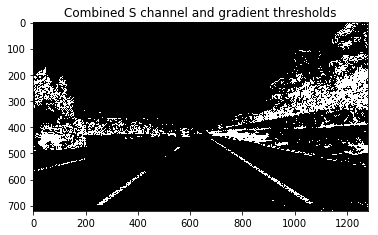

In [7]:
# LANE ISOLATING PIPELINE TEST 
img = cv2.imread(test_images[2])
img = cv2.cvtColor(cv2.undistort(img,mtx,dist,None,mtx),cv2.COLOR_BGR2RGB)
binary_warped = tresholds(img)

# Plotting thresholded images

plt.title('Combined S channel and gradient thresholds')
plt.imshow(binary_warped, cmap='gray')

In [8]:
#SOURCE RECTANGLE POINTS
src = np.float32([(565,460),
                  (728,460), 
                  (1195,685), 
                  (150,685)])

#WARPED RECTANGLE POINTS    
dst = np.float32([(350,0), 
                  (img.shape[1]-350,0), 
                  (img.shape[1]-350,img.shape[0]),
                  (350,img.shape[0])])

#PERSPECTIVE TRANSFORM
M = cv2.getPerspectiveTransform(src, dst)
#INVERSE PERSPECTIVE TRANSFORM
M_inv = cv2.getPerspectiveTransform(dst, src)




In [9]:
def warp(img,M):
    '''
    Image perspective transform, from camera view to cenital view
    '''
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

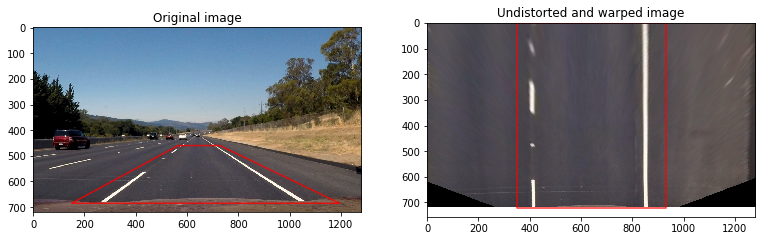

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_or,cv2.COLOR_BGR2RGB))   # Plot the raw image
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
plt.plot(x, y, color='r', alpha=0.8, linewidth=1.5)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(warp(img,M))            #Plot the undistorted image
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
plt.plot(x, y, color='r', alpha=0.8, linewidth=1.5)
plt.title("Undistorted and warped image")

In [11]:
def polyfit_sliding_window(binary_warped):
    '''
    Provided by Udacity, sliding window method implemenattion for lane lines
    identification and second order polynomial fit in order to obtain curvature
    and center displacement calculations
    '''
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 40
    # Set minimum number of pixels found to recenter window
    minpix = 20
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def polyfit_next_frame(left_fit,right_fit,binary_warped): 
    '''
    Provided by Udacity, lane lines identification with a previous estimation
    of the probable location
    '''
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 40
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_lane_inds, right_lane_inds




(720, 0)

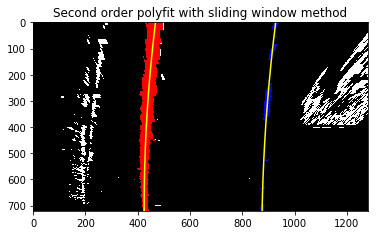

In [12]:
# LANE ISOLATING PIPELINE TEST 
img = cv2.imread(test_images[3])
img = cv2.cvtColor(cv2.undistort(img,mtx,dist,None,mtx),cv2.COLOR_BGR2RGB)
binary_warped = warp(tresholds(img),M)

#SLIDING WINDOW METHOD APLIED TO AN EXAMPLE TEST IMAGE

left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_sliding_window(binary_warped)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.title('Second order polyfit with sliding window method')
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [13]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_center(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    '''
    Based on Udacity recomendation in the final project class,
    returns the curvature value and lane center deviation converted from pixel 
    to metric space
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = (bin_img.shape[1])/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

def draw_lane(original_img, binary_img, l_fit, r_fit, Minv, curv_rad, center_dist):
    '''
    Based on Udacity sugestions, returns the original undistorted image 
    with all the information and detected lane path added
    '''
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Curve radius: ' + '{:06.3f}'.format(curv_rad) + 'm'
    cv2.putText(result, text, (375,70), font, 1.3, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:06.4f}'.format(abs_center_dist) + 'm ' + direction + ' from center'
    cv2.putText(result, text, (375,120), font, 1.3, (255,255,255), 2, cv2.LINE_AA)
    return result


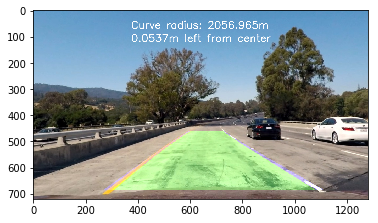

In [14]:
#EXAMPLE OF FULLY PROCESSED TEST IMAGE

left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_sliding_window(binary_warped)
rad_l, rad_r, d_center = calc_curv_rad_center(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
exampleImg_out1 = draw_lane(img, binary_warped, left_fit, right_fit, M_inv,(rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out1)




In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    '''
    Based on Udacity recomendations I developed a Line class that performs 
    sanity checks to load a correct considered fit to the best fit array 
    which provides of first aproximation to the polyfit_next_frame function
    '''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def new_fit(self, fit, inds):
        # Add the fit obtained to the line if considered good fit
        if fit is not None:
            if self.best_fit is not None:
                # if sliding or next frame obtained a new best fit compare 
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.01 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # New best fit does not seem to be the searched line
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 10:
                    # throw out other fits
                    self.current_fit = self.current_fit[len(self.current_fit)-10:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

In [16]:
def process_img(img):
    or_img = np.copy(img)
    img = cv2.undistort(img,mtx,dist,None,mtx)
    binary_warped = tresholds(img)
    binary_warped = warp(binary_warped,M)
    
    processed = np.dstack((binary_warped*255, binary_warped*255, binary_warped*255))
    process = True #If false, fot test pourpouses the warped and tresholded image is returned 
    
    if process :
    
        # ONCE BIANRY IS GENERATED DECIDE BETWEEN LANE FINDING METHOD 
        if not l_line.detected or not r_line.detected:
            #print('sliding')
            left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_sliding_window(binary_warped)
        else:   
            #print('next')
            left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_next_frame(l_line.best_fit,r_line.best_fit,binary_warped)
    
        if left_fit is not None and right_fit is not None:
            # calculate x cordenate for fits in image bottom
            #print('found')
            h = img.shape[0]
            l_fit_x_bot = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
            r_fit_x_bot = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
            x_int_diff = abs(r_fit_x_bot-l_fit_x_bot)
            #print (x_int_diff)
            if abs(500 - x_int_diff) > 100: #500
                #print('discard')
                left_fit = None
                right_fit = None
            
        l_line.new_fit(left_fit, left_lane_inds)
        r_line.new_fit(right_fit, right_lane_inds)
        
        if l_line.best_fit is not None and r_line.best_fit is not None:
            #print('correct')
            rad_l, rad_r, d_center = calc_curv_rad_center(binary_warped, l_line.best_fit, r_line.best_fit, left_lane_inds, right_lane_inds) 
            processed = draw_lane(img, binary_warped, l_line.best_fit, r_line.best_fit, M_inv,(rad_l+rad_r)/2, d_center)
        else:
            processed = or_img
            print('fail')
        

    return processed
        

[  1.08633630e-04  -1.36089999e-01   9.17192388e+02]


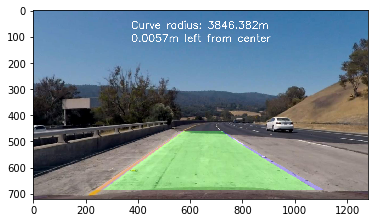

In [17]:
image = cv2.imread(test_images[0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
l_line = Line()
r_line = Line()

exampleImg_out1 = process_img(image)
plt.imshow(exampleImg_out1)
#plt.imshow(binary, cmap = 'gray')
print(r_line.best_fit)


In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

l_line = Line()
r_line = Line()

white_output = 'videos/project_video_out.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")
#clip1.save_frame("challenge01.jpeg", t=24) # saves the frame at time = 24s
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_out.mp4
[MoviePy] Writing video videos/project_video_out.mp4


100%|█████████▉| 1260/1261 [02:54<00:00,  7.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_out.mp4 

CPU times: user 3min 32s, sys: 46.9 s, total: 4min 19s
Wall time: 2min 55s
